In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
def lin_interp(x, y, xq):
    """Simple linear interpolation y(xq) given tabulated (x,y)."""
    return np.interp(xq, x, y)

def nm_to_m(x_nm):
    return np.asarray(x_nm) * 1e-9

def um_to_m(x_um):
    return np.asarray(x_um) * 1e-6

# -----------------------------
# Photonics primitives (2x2)
# -----------------------------
def coupler_matrix(k=0.5):
    """
    Lossless symmetric directional coupler.
    k: power cross-coupling (0..1)
    """
    k = float(k)
    t = np.sqrt(1.0 - k)
    kap = np.sqrt(k)
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0, 0] = t
    matrix[0, 1] = 1j * kap
    matrix[1, 0] = 1j * kap
    matrix[1, 1] = t
    return matrix

def phase_matrix(phi):
    """Differential phase matrix."""
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0, 0] = np.exp(-1j * phi / 2.0)
    matrix[0, 1] = 0.0
    matrix[1, 0] = 0.0
    matrix[1, 1] = np.exp(+1j * phi / 2.0)
    return matrix

def delay_matrix(L_um, neff, wl_um, bias=0.0):
    """Delay matrix: P(phi) with phi = beta*L + bias."""
    phi = 2*np.pi*L_um*neff/wl_um + bias
    return phase_matrix(phi)

def leaf_matrix(lambda_um, neff_lambda, k_in, k_out, dL_um, phi_bias=0.0):
    """Single-stage MZI: C_out * P(phi) * C_in."""
    return (coupler_matrix(k_out) @ 
            delay_matrix(dL_um, neff_lambda, lambda_um, phi_bias) @ 
            coupler_matrix(k_in))

def root_matrix(lambda_um, neff_lambda, k1, k2, k3,
                dL0a_um, dL0b_um, phi0a_bias=0.0, phi0b_bias=0.0):
    """2-delay, 3-coupler root: C3 * P(phi_b) * C2 * P(phi_a) * C1."""
    return (coupler_matrix(k3) @ 
            delay_matrix(dL0b_um, neff_lambda, lambda_um, phi0b_bias) @
            coupler_matrix(k2) @
            delay_matrix(dL0a_um, neff_lambda, lambda_um, phi0a_bias) @
            coupler_matrix(k1))

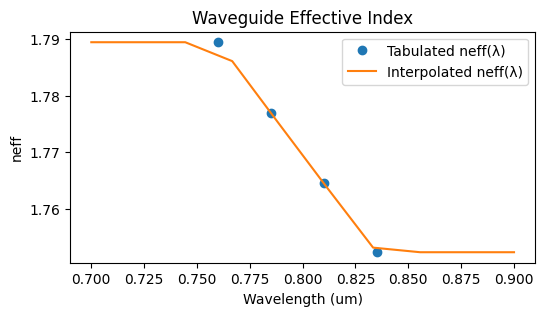


For wavelength 700.00 nm:
neff = 1.789460
Phase/um = 16.06 rad/um

For wavelength 722.22 nm:
neff = 1.789460
Phase/um = 15.57 rad/um

For wavelength 744.44 nm:
neff = 1.789460
Phase/um = 15.10 rad/um

For wavelength 766.67 nm:
neff = 1.786117
Phase/um = 14.64 rad/um

For wavelength 788.89 nm:
neff = 1.774987
Phase/um = 14.14 rad/um

For wavelength 811.11 nm:
neff = 1.763941
Phase/um = 13.66 rad/um

For wavelength 833.33 nm:
neff = 1.753109
Phase/um = 13.22 rad/um

For wavelength 855.56 nm:
neff = 1.752297
Phase/um = 12.87 rad/um

For wavelength 877.78 nm:
neff = 1.752297
Phase/um = 12.54 rad/um

For wavelength 900.00 nm:
neff = 1.752297
Phase/um = 12.23 rad/um


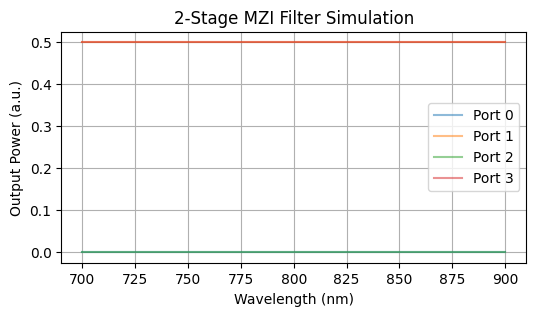

In [4]:
# Simulate given
L1 = 6  # Root 1 um
L2 = 6  # Root 2 um
L3 = 3  # Leaf A um
L4 = 3  # leaf B um
k1 = 0.5  # Root coupler 1
k2 = 0.5  # Root coupler 2
k3 = 0.5  # Root coupler 3
k4 = 0.5  # Leaf coupler in
k5 = 0.5  # Leaf coupler out

# Simulation Range - All units um
wl_min = 700e-3
wl_max = 900e-3
num_points = 10

# Input injection
Ein = np.array([1.0, 0.0], dtype=complex)

# Fixed parameters - for interpolating neff(λ)
wg_neff = np.array([1.78946, 1.776922, 1.764483, 1.752297], dtype=float)  # TE
wg_lambda_um = np.array([0.760, 0.785, 0.810, 0.835], dtype=float)  # TE

# Prepare to simulate
# wavelength grid
wl_space_um = np.linspace(wl_min, wl_max, num_points)

# interpolate neff over grid
neff_interpd = np.interp(x = wl_space_um, xp = wg_lambda_um, fp = wg_neff)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(wg_lambda_um, wg_neff, 'o', label='Tabulated neff(λ)')
ax.plot(wl_space_um , neff_interpd, '-', label='Interpolated neff(λ)')
ax.set_title('Waveguide Effective Index')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('neff')
ax.legend()
plt.show()

# initialize output power
p0 = np.zeros_like(wl_space_um, dtype=float)
p1 = np.zeros_like(wl_space_um, dtype=float)
p2 = np.zeros_like(wl_space_um, dtype=float)
p3 = np.zeros_like(wl_space_um, dtype=float)

for i, wl in enumerate(wl_space_um):
    neff_wl = neff_interpd[i]
    print(f"\nFor wavelength {wl*1e3:.2f} nm:\nneff = {neff_wl:.6f}")
    print(f"Phase/um = {2*np.pi*neff_wl/wl:.2f} rad/um")
    # root
    root = root_matrix(wl, neff_wl, k1, k2, k3, um_to_m(L1), um_to_m(L2))
    Ebranch = root @ Ein
    E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
    # Upper is fed to leaf 1, lower to leaf 2

    # leaves
    leaf_a = leaf_matrix(wl, neff_wl, k4, k5, um_to_m(L3))
    leaf_b = leaf_matrix(wl, neff_wl, k4, k5, um_to_m(L4))

    Eout_leaf_1 = leaf_a @ np.array([E_to_leaf_1, 0.0], dtype=complex)
    Eout_leaf_2 = leaf_b @ np.array([E_to_leaf_2, 0.0], dtype=complex)
    p0[i] = np.abs(Eout_leaf_1[0])**2  # Port 0
    p1[i] = np.abs(Eout_leaf_1[1])**2  # Port 1
    p2[i] = np.abs(Eout_leaf_2[0])**2  # Port 2
    p3[i] = np.abs(Eout_leaf_2[1])**2  # Port 3


# Plot results
plt.figure(figsize=(6, 3))
plt.plot(wl_space_um * 1e3, p0, label='Port 0', alpha=0.5)
plt.plot(wl_space_um * 1e3, p1, label='Port 1', alpha=0.5)
plt.plot(wl_space_um * 1e3, p2, label='Port 2', alpha=0.5)
plt.plot(wl_space_um * 1e3, p3, label='Port 3', alpha=0.5)
plt.title('2-Stage MZI Filter Simulation')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Output Power (a.u.)')
plt.legend()
plt.grid(True)
plt.show()


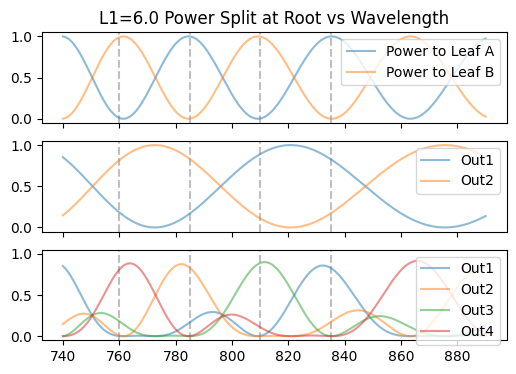

In [20]:


delay1 = 5.96
delay2 = 3.033
delay1 = 6.033 - 0.073
delay2 = 3.033
# Simulate given
L1 = delay1  # Root 1 um
L3 = delay2  # Leaf A um
L4 = delay2  # leaf B um
k1 = 0.5  # Root coupler 1
k2 = 0.5  # Root coupler 2
k3 = 0.5  # Root coupler 3
k4 = 0.5  # Leaf coupler in
k5 = 0.5  # Leaf coupler out

# Simulation Range - All units um
wl_min = 740e-3
wl_max = 890e-3
num_points = 1000
wl_space_um = np.linspace(wl_min, wl_max, num_points)

# Input injection
Ein = np.array([1.0, 0.0], dtype=complex)

# Fixed parameters - for interpolating neff(λ)
wg_neff = np.array([1.78946, 1.776922, 1.764483, 1.752297], dtype=float)  # TE
wl_um = np.array([0.760, 0.785, 0.810, 0.835], dtype=float)  # TE
# Interpolate neff with a linear fit
def linfit(x, m, b=0):
    return m*x + b
pOpt, pCov = curve_fit(linfit, wl_um, wg_neff)
def neff_fit_func(wl_um):
    return linfit(wl_um, *pOpt)

# fig, ax = plt.subplots(1, 1, figsize=(6,3))
# ax.plot(wg_lambda_um, wg_neff, 'o', label='Tabulated neff(λ)')
# ax.plot(wl_space_um , neff_fit_func(wl_space_um), '-', label='Fitted neff(λ)')
# ax.set_title('Waveguide Effective Index')
# ax.set_xlabel('Wavelength (um)')
# ax.set_ylabel('neff')
# ax.legend()
# plt.show()

p_a = []
p_b = []
p_l1 = []
p_l2 = []
p_l3 = []
p_l4 = []
p_leaf_test1 = []
p_leaf_test2 = []
for i, wl in enumerate(wl_space_um):
    n_eff_wl = neff_fit_func(wl)
    phi_per_um = 2*np.pi*n_eff_wl/wl

    # Root
    DC1 = coupler_matrix(k1)
    DC2 = coupler_matrix(k2)
    P1 = delay_matrix(L1, n_eff_wl, wl)
    root = DC2 @ P1 @ DC1
    
    Ebranch = root @ Ein
    E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
    p_a.append(np.abs(E_to_leaf_1)**2)
    p_b.append(np.abs(E_to_leaf_2)**2)

    E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
    E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)
    # Leaf A
    DC4 = coupler_matrix(k4)  # Leaf A
    DC5 = coupler_matrix(k5)  # Leaf A
    P3 = delay_matrix(L3, n_eff_wl, wl)  # Leaf A
    leaf_a = DC5 @ P3 @ DC4
    
    EleafA = leaf_a @ Ein
    EA_1, EA_2 = EleafA[0], EleafA[1]
    p_leaf_test1.append(np.abs(EA_1)**2)
    p_leaf_test2.append(np.abs(EA_2)**2)
    EleafA = leaf_a @ E_input_to_leaf_1
    EA_1, EA_2 = EleafA[0], EleafA[1]

    # Leaf B
    DC6 = coupler_matrix(k4)  # Leaf B
    DC7 = coupler_matrix(k5)  # Leaf B
    P4 = delay_matrix(L4, n_eff_wl, wl)  # Leaf
    leaf_b = DC7 @ P4 @ DC6

    EleafB = leaf_b @ E_input_to_leaf_2
    EB_1, EB_2 = EleafB[0], EleafB[1]

    p_l1.append(np.abs(EA_1)**2)
    p_l2.append(np.abs(EA_2)**2)
    p_l3.append(np.abs(EB_1)**2)
    p_l4.append(np.abs(EB_2)**2)
    # break
scale = "log"
scale = "linear"

fig, axs = plt.subplots(3, 1, figsize=(6,4), sharex=True, sharey=True)
ax_root, ax_leaf1, ax_leaf2 = axs
for wl_target in wl_um:
    ax_root.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf1.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf2.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
ax_root.plot(wl_space_um * 1e3, p_a, label='Power to Leaf A', alpha=0.5)
ax_root.plot(wl_space_um * 1e3, p_b, label='Power to Leaf B', alpha=0.5)
ax_root.set_title(f'L1={L1:.1f} Power Split at Root vs Wavelength')
ax_root.set(yscale=scale)
ax_root.legend(loc='upper right')

ax_leaf1.plot(wl_space_um * 1e3, p_leaf_test1, label='Out1', alpha=0.5)
ax_leaf1.plot(wl_space_um * 1e3, p_leaf_test2, label='Out2', alpha=0.5)
# ax_leaf1.set_title('Power Split at Leaf vs Wavelength')
ax_leaf1.set(yscale=scale)
ax_leaf1.legend(loc='upper right')

ax_leaf2.plot(wl_space_um * 1e3, p_l1, label='Out1', alpha=0.5)
ax_leaf2.plot(wl_space_um * 1e3, p_l2, label='Out2', alpha=0.5)
ax_leaf2.plot(wl_space_um * 1e3, p_l3, label='Out3', alpha=0.5)
ax_leaf2.plot(wl_space_um * 1e3, p_l4, label='Out4', alpha=0.5)
# ax_leaf2.set_title('Power Split at Leaf vs Wavelength')
ax_leaf2.set(yscale=scale)
ax_leaf2.legend(loc='upper right')
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.optimize import curve_fit

In [9]:
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import numpy as np

def simulate_and_plot(L1, dL2):
    L2 = 2.0 * L1 + dL2  # constrained + detuned

    p_a, p_b = [], []
    p_l1, p_l2, p_l3, p_l4 = [], [], [], []

    for wl in wl_space_um:
        n_eff_wl = neff_fit_func(wl)

        # Root
        DC1 = coupler_matrix(k1)
        DC2 = coupler_matrix(k2)
        DC3 = coupler_matrix(k3)
        P1 = delay_matrix(L1, n_eff_wl, wl)
        P2 = delay_matrix(L2, n_eff_wl, wl)
        root =  DC2 @ P1 @ DC1

        Ebranch = root @ Ein
        E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
        p_a.append(np.abs(E_to_leaf_1)**2)
        p_b.append(np.abs(E_to_leaf_2)**2)

        E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
        E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)

        # Leaf A
        DC4 = coupler_matrix(k4)
        DC5 = coupler_matrix(k5)
        P3 = delay_matrix(L3, n_eff_wl, wl)
        leaf_a = DC5 @ P3 @ DC4
        EleafA = leaf_a @ E_input_to_leaf_1
        EA_1, EA_2 = EleafA[0], EleafA[1]

        # Leaf B
        DC6 = coupler_matrix(k4)
        DC7 = coupler_matrix(k5)
        P4 = delay_matrix(L4, n_eff_wl, wl)
        leaf_b = DC7 @ P4 @ DC6
        EleafB = leaf_b @ E_input_to_leaf_2
        EB_1, EB_2 = EleafB[0], EleafB[1]

        p_l1.append(np.abs(EA_1)**2)
        p_l2.append(np.abs(EA_2)**2)
        p_l3.append(np.abs(EB_1)**2)
        p_l4.append(np.abs(EB_2)**2)

    # Plot: root split
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    for wl_target in wl_um:
        ax.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)

    ax.plot(wl_space_um * 1e3, p_a, label='Power to Leaf A', alpha=0.7)
    ax.plot(wl_space_um * 1e3, p_b, label='Power to Leaf B', alpha=0.7)

    ax.set_title(f'Root Split vs Wavelength\nL1={L1:.3f} µm, L2={L2:.3f} µm (dL2={dL2:.3f} µm)')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Power')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.2)
    plt.show()

interact(
    simulate_and_plot,
    L1=FloatSlider(
        value=1.0, min=0.2, max=20.0, step=0.01,
        description='L1 (µm)', continuous_update=False
    ),
    dL2=FloatSlider(
        value=0.0, min=0.0, max=3.0, step=0.001,
        description='dL2 (µm)', continuous_update=False
    )
);


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='L1 (µm)', max=20.0, min=0.2…